<a href="https://colab.research.google.com/github/sayakpaul/Supervised-Constrastive-Learning-in-TensorFlow-2/blob/master/Contrastive_Training_Pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [35]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [36]:
!nvidia-smi

Fri Jun 23 17:15:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8     6W /  80W |    356MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install wandb
import wandb
wandb.login()

wandb: Currently logged in as: burkinabe (master-thesis-uvbf). Use `wandb login --relogin` to force relogin


True

In [ ]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

In [37]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

## Pets dataset

In [55]:
train_data_dir = "data/train"
batch_size = 32
img_height = 510
img_width = 503

In [56]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6984 files belonging to 2 classes.
Using 5588 files for training.


In [57]:
val_data_dir = "data/val"

In [58]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 873 files belonging to 2 classes.
Using 174 files for validation.


In [59]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malicious']


2023-06-23 17:19:47.259854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5588]
	 [[{{node Placeholder/_0}}]]
2023-06-23 17:19:47.260255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5588]
	 [[{{node Placeholder/_4}}]]


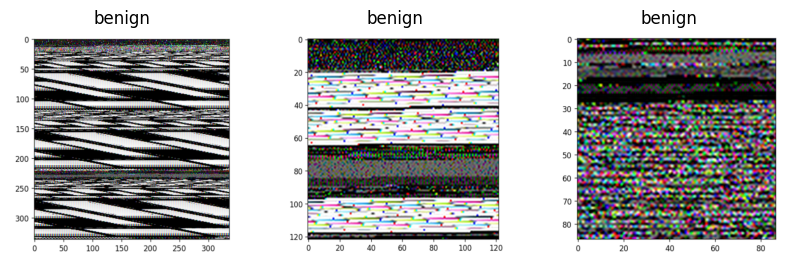

In [60]:
# Reference: https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data pipeline

In [61]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-06-23 17:19:52.132195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5588]
	 [[{{node Placeholder/_4}}]]
2023-06-23 17:19:52.132440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5588]
	 [[{{node Placeholder/_4}}]]


(32, 510, 503, 3)
(32,)


In [62]:
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (img_height, img_width))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(batch_size)
    .prefetch(AUTO)
)
   

## Model building

In [63]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [64]:

# Encoder Network
def encoder_net():
	inputs = Input((img_height, img_width, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(128, activation="relu"),
		UnitNormLayer()
	])

	return projector

## Running forward passes on a single image

In [ ]:
encoder_r = encoder_net()
projector_z = projector_net()

images, _ = next(iter(train_ds))
r = encoder_r(images[0], 0)
z = projector_z(r)

print(tf.shape(r))
print(tf.shape(z))

2023-06-23 17:20:03.811357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5588]
	 [[{{node Placeholder/_4}}]]
2023-06-23 17:20:03.811667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5588]
	 [[{{node Placeholder/_4}}]]


## Training the encoder and the projector

In [49]:
optimizer = tf.keras.optimizers.Adam()

In [50]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels, metric='cosine')

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

In [51]:
from tensorflow.python.ops.numpy_ops import np_config
# Enable numpy-related methods in TensorFlow
np_config.enable_numpy_behavior()

In [52]:
#wandb.init(project="scl", entity="authors", id="supervised-contrastive-crctd")
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
    epoch_loss_avg = tf.keras.metrics.Mean()
    
    for (images, labels) in train_ds:
        print(labels.shape)
        loss = train_step(images[0], labels)
        epoch_loss_avg.update_state(loss) 

    train_loss_results.append(epoch_loss_avg.result())
    print("supervised_contrastive_loss : {}", epoch_loss_avg.result())

    if epoch % LOG_EVERY == 0:
        print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
print("training_time : {}", (end - start))

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

  0%|          | 0/60 [00:00<?, ?it/s]

(3, 3)


ValueError: in user code:

    File "/tmp/ipykernel_41911/3649237080.py", line 9, in train_step  *
        loss = losses.max_margin_contrastive_loss(z, labels, metric='cosine')
    File "/home/aksavadogo/codespace/memoire/Supervised-Contrastive-Learning-in-TensorFlow-2/Pets/losses.py", line 68, in max_margin_contrastive_loss  *
        loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    File "/home/aksavadogo/anaconda3/envs/thesis/lib/python3.10/site-packages/tensorflow_addons/losses/contrastive.py", line 68, in contrastive_loss  *
        tf.math.maximum(margin - y_pred, 0.0)

    ValueError: Dimensions must be equal, but are 36 and 3 for '{{node mul}} = Mul[T=DT_FLOAT](Cast, Square)' with input shapes: [36], [3].


## Supervised training

In [ ]:
validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

In [ ]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(1)(r)

	supervised_model = Model(inputs, outputs)

	return supervised_model

In [18]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.BinaryAccuracy()])

wandb.init(project="scl", entity="authors")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback(), es])

Epoch 1/50
309/309 [==============================] - 44s 143ms/step - loss: 0.2342 - binary_accuracy: 0.9188 - val_loss: 0.2603 - val_binary_accuracy: 0.9008
Epoch 2/50
309/309 [==============================] - 43s 138ms/step - loss: 0.0967 - binary_accuracy: 0.9698 - val_loss: 0.2747 - val_binary_accuracy: 0.9014
Epoch 3/50
309/309 [==============================] - 43s 138ms/step - loss: 0.0860 - binary_accuracy: 0.9704 - val_loss: 0.2886 - val_binary_accuracy: 0.9008
Epoch 00003: early stopping


In [19]:
# Lowering the learning rate
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.BinaryAccuracy()])

wandb.init(project="scl", entity="authors", id="low-lr")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback(), es])

Epoch 1/50
309/309 [==============================] - 45s 147ms/step - loss: 0.5850 - binary_accuracy: 0.5262 - val_loss: 0.5164 - val_binary_accuracy: 0.7357
Epoch 2/50
309/309 [==============================] - 43s 141ms/step - loss: 0.4098 - binary_accuracy: 0.9144 - val_loss: 0.4071 - val_binary_accuracy: 0.8773
Epoch 3/50
309/309 [==============================] - 44s 142ms/step - loss: 0.3026 - binary_accuracy: 0.9555 - val_loss: 0.3434 - val_binary_accuracy: 0.8891
Epoch 4/50
309/309 [==============================] - 43s 140ms/step - loss: 0.2357 - binary_accuracy: 0.9620 - val_loss: 0.3061 - val_binary_accuracy: 0.8951
Epoch 5/50
309/309 [==============================] - 43s 138ms/step - loss: 0.1922 - binary_accuracy: 0.9638 - val_loss: 0.2841 - val_binary_accuracy: 0.8971
Epoch 6/50
309/309 [==============================] - 43s 139ms/step - loss: 0.1629 - binary_accuracy: 0.9652 - val_loss: 0.2712 - val_binary_accuracy: 0.8985
Epoch 7/50
309/309 [==========================

With more training for the encoder and the projector, we would have got better results. We did not use any augmentation policy for either of the trainings above, so including that would have also helped us enhance the performance. 

## Serialize the model weights to GCS

In [22]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [23]:
!gsutil mb gs://supervised-contrastive

Creating gs://supervised-contrastive/...


In [24]:
time_now = time.time()
encoder_r.save_weights("encoder_r_" + str(time_now) + ".h5")
projector_z.save_weights("projector_z" + str(time_now) + ".h5")

!gsutil -m cp -r *.h5 gs://supervised-contrastive/

Copying file://encoder_r_1590489813.9405909.h5 [Content-Type=application/octet-stream]...
Copying file://projector_z1590489813.9405909.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 2 objects/91.2 MiB.                                     
